# Natural Language Processing with Disaster Tweets

######                   Real or Fake?  ---  Disaster Tweets with NLP

## Import necessary modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
from time import process_time 

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

import contractions

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import * 

## Load Data

In [2]:
# read the train csv file
train_df = pd.read_csv(r"train.csv")

# read the test csv file
test_df = pd.read_csv(r"test.csv")

# read the submission csv file
submission_df = pd.read_csv(r"sample_submission.csv")

## Explore Data

In [3]:
# glimpse at the train data
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# glimpse at the test data
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
# glimpse at the test data
submission_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [6]:
print('There are {} rows and {} columns in train'.format(train_df.shape[0],train_df.shape[1]))
print('There are {} rows and {} columns in train'.format(test_df.shape[0],test_df.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


In [7]:
# show summary of the train data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
# show summary of the test data
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [9]:
# print statistics of the train data
train_df.describe(include='all')

,id,keyword,location,text,target
count,7613.00,7552,5080,7613,7613.00
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.93,NaN,NaN,NaN,0.43
std,3137.12,NaN,NaN,NaN,0.50
min,1.00,NaN,NaN,NaN,0.00
25%,2734.00,NaN,NaN,NaN,0.00
50%,5408.00,NaN,NaN,NaN,0.00
75%,8146.00,NaN,NaN,NaN,1.00


In [10]:
# print statistics of the test data
test_df.describe(include='all')

,id,keyword,location,text
count,3263.00,3237,2158,3263
unique,NaN,221,1602,3243
top,NaN,deluged,New York,11-Year-Old Boy Charged With Manslaughter of T...
freq,NaN,23,38,3
mean,5427.15,NaN,NaN,NaN
std,3146.43,NaN,NaN,NaN
min,0.00,NaN,NaN,NaN
25%,2683.00,NaN,NaN,NaN
50%,5500.00,NaN,NaN,NaN
75%,8176.00,NaN,NaN,NaN


In [11]:
# print unique values counts of target variable
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Visualizing the Tweets

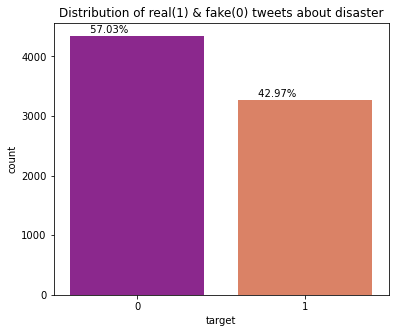

In [12]:
# Visualizations for the count of target variables

plt.figure(figsize=(6,5))
plt.title("Distribution of real(1) & fake(0) tweets about disaster")
p1 = sns.countplot(train_df['target'], palette = 'plasma')

for p in p1.patches:
        p1.annotate('{:6.2f}%'.format(p.get_height()/len(train_df['target'])*100), (p.get_x()+0.1, p.get_height()+50))
        
plt.show()

__`The data is not that much imbalanced`__

# Pre-processing

### Identify missing data

In [13]:
# print total count of null values by features of train data
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [14]:
# print total count of null values by features of test data
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

Ignore the null values of the features 

    - keyword
    - location

Consider this features only for the model

    - text
    - target

### Dropping unwanted columns

In [15]:
del train_df['id']
del train_df['keyword']
del train_df['location']

del test_df['id']
del test_df['keyword']
del test_df['location']

In [16]:
train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
test_df.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


## Data Cleaning

### Functions to clean the data

In [18]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [54]:
# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

# To expand some english text to full form
def expand(text):
    
    expanded_words = []
    
    for word in text.split():
        expanded_words.append(contractions.fix(word))
    
    expanded_text = ' '.join(expanded_words)
    
    return expanded_text


# To lower the text, remove numbers, html tags, special characters, punctuations, non-ascii values
def remove_unwanted(text):
    text = re.sub(r"\n","",text)
    text = text.lower() #lower the text
    #text = re.sub(r"\d","",text) #remove digits
    text = re.sub(r'[^\x00-\x7f]',r' ',text) #remove non-ascii
    text = re.sub(r'[^\w\s]','',text) #remove punctuation
    #text = re.sub(r'http\S+|www.\S+', '', text) #remove http
    return text

# Overall function
def clean_text(text):
    text = text.lower()
    text = replace_abbrev(text)
    text = expand(text)
    text = remove_unwanted(text)
    return text


In [55]:
train_df['clean_text'] = train_df['text'].apply(lambda x : clean_text(x))
test_df['clean_text'] = test_df['text'].apply(lambda x : clean_text(x))

In [56]:
train_df.head()

,text,target,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [57]:
test_df.head()

,text,clean_text
0,Just happened a terrible car crash,just happened a terrible car crash
1,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...
2,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...
3,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan


### Text Normalization - Vectorization

In [58]:
max_features=5000

count_vectorizer = CountVectorizer(max_features=max_features)
sparce_matrix_train = count_vectorizer.fit_transform(train_df['clean_text'])
sparce_matrix_test = count_vectorizer.fit_transform(test_df['clean_text'])

def count_vector(data):
    count_vectorizer = CountVectorizer()
    vect = count_vectorizer.fit_transform(data)
    return vect, count_vectorizer

X_train_count, count_vectorizer = count_vector(train_df['clean_text'])
X_test_count = count_vectorizer.transform(test_df['clean_text'])                                                     

## Model Building

In [59]:
X = X_train_count
y = train_df.target.to_numpy()

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.3)

In [60]:
model = MultinomialNB()

model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

### Model Evaluation

In [61]:
print("F1 Score =", f1_score(y_test, y_pred))

F1 Score = 0.750816104461371


In [62]:
print("Accuracy =", accuracy_score(y_test, y_pred))

Accuracy = 0.7994746059544658


In [63]:
print("Report:\n", classification_report(y_test, y_pred))

Report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1301
           1       0.81      0.70      0.75       983

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [64]:
print('Confusion Matrix:')
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

Confusion Matrix:


array([[1136,  165],
       [ 293,  690]], dtype=int64)

In [65]:
y_pred_test = model.predict(X_test_count)

## Submission

In [66]:
submission_df["target"] = y_pred_test

In [67]:
submission_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [68]:
submission_df.shape

(3263, 2)

In [69]:
submission_df.to_csv('Submission10.csv', index=False)